In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the datasets

In [173]:
df_3 = pd.read_csv("Use Case - Onboarding effectiveness - 3 months data.csv")
df_6 = pd.read_csv("Use Case - Onboarding Effectiveness - 6 months data.csv")

In [174]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7014 entries, 0 to 7013
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7014 non-null   int64  
 1   ID                   7014 non-null   float64
 2   Reached_3w           7014 non-null   float64
 3   Reached_3m           7014 non-null   float64
 4   Tenure_In_Months     7014 non-null   float64
 5   Date_Joined          7014 non-null   object 
 6   FUA_Balance          7014 non-null   float64
 7   Number_Of_Services   7014 non-null   float64
 8   Has_Payroll          7014 non-null   float64
 9   Income               508 non-null    float64
 10  Has_Investment       7014 non-null   float64
 11  Has_Visa             7014 non-null   float64
 12  VISA_balance         7014 non-null   float64
 13  Has_mortgage         7014 non-null   float64
 14  Has_Deposit          7014 non-null   float64
 15  Number_Transactions  7014 non-null   f

In [175]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6023 entries, 0 to 6022
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6023 non-null   int64  
 1   Reached_3w           6023 non-null   int64  
 2   Reached_3m           6023 non-null   int64  
 3   Tenure_In_Months     6023 non-null   int64  
 4   Date_Joined          6023 non-null   object 
 5   FUA_Balance          6023 non-null   float64
 6   Number_Of_Services   6023 non-null   int64  
 7   Has_Payroll          6023 non-null   int64  
 8   Income               431 non-null    float64
 9   Has_Investment       6023 non-null   int64  
 10  Has_Visa             6023 non-null   int64  
 11  VISA_balance         6023 non-null   float64
 12  Has_mortgage         6023 non-null   int64  
 13  Has_Deposit          6023 non-null   int64  
 14  Number_Transactions  6023 non-null   int64  
 15  Age                  6023 non-null   i

In [176]:
df_3.drop(["Unnamed: 0", "Income", "Unnamed: 17"], axis=1, inplace=True)

# To make sure everything is 0 or 1, not float
columns_to_convert = ['Has_Payroll', 'Has_Investment', 'Has_Visa', 'Has_mortgage', 'Has_Deposit']
for column in columns_to_convert:
    df_3[column] = df_3[column].astype(int).astype(str)
    df_6[column] = df_6[column].astype(int).astype(str)


# 2. Enrich the dataset for proper analysis

## 2.1 Create Age bins

In [177]:
df_3['Age'].describe(), df_6['Age'].describe()

(count    7014.000000
 mean       54.303821
 std        12.421983
 min        23.000000
 25%        45.000000
 50%        54.000000
 75%        63.000000
 max       105.000000
 Name: Age, dtype: float64,
 count    6023.000000
 mean       54.356467
 std        12.417337
 min        23.000000
 25%        46.000000
 50%        54.000000
 75%        63.000000
 max        91.000000
 Name: Age, dtype: float64)

In [178]:
# Create age bins
bins = [18, 30, 60, np.inf]
labels = ['Young', 'Middle-aged', 'Senior']

df_3['Age_Bin'] = pd.cut(df_3['Age'], bins=bins, labels=labels)
df_6['Age_Bin'] = pd.cut(df_6['Age'], bins=bins, labels=labels)

## 2.2 Categorize Call Actions into 4 categories

In [179]:
# Categorize calls based on "No call", "Called 3W", "Called 3M", "Called Both"
def categorize_calls(week_3, month_3):
    if week_3 == 0 and month_3 == 0:
        return 'No call'
    elif week_3 == 1 and month_3 == 0:
        return 'Called 3w'
    elif week_3 == 0 and month_3 == 1:
        return 'Called 3m'
    else:
        return 'Called both'

df_3['Call_Category'] = df_3.apply(lambda row: categorize_calls(row['Reached_3w'], row['Reached_3m']), axis=1)
df_6['Call_Category'] = df_6.apply(lambda row: categorize_calls(row['Reached_3w'], row['Reached_3m']), axis=1)

df_3.head()

,ID,Reached_3w,Reached_3m,Tenure_In_Months,Date_Joined,FUA_Balance,Number_Of_Services,Has_Payroll,Has_Investment,Has_Visa,VISA_balance,Has_mortgage,Has_Deposit,Number_Transactions,Age,City,Age_Bin,Call_Category
0,2613.0,0.0,0.0,3.0,7/15/2020,944.35,2.0,1,0,0,0.000000,0,1,45.0,49.0,SURREY ...,Middle-aged,No call
1,3382.0,1.0,1.0,3.0,1/21/2021,1589.61,2.0,0,0,1,676.347873,0,1,25.0,69.0,PENDER ISLAND ...,Senior,Called both
2,3927.0,1.0,1.0,3.0,8/14/2020,1000.00,3.0,1,0,1,326.556766,0,1,0.0,59.0,BURNABY ...,Middle-aged,Called both
3,4065.0,1.0,1.0,3.0,6/26/2020,219.41,1.0,0,0,1,0.000000,0,1,0.0,71.0,VANCOUVER ...,Senior,Called both
4,4221.0,0.0,0.0,3.0,12/18/2020,76.09,1.0,0,0,1,1315.930929,0,1,66.0,65.0,VANCOUVER ...,Senior,No call


In [180]:
print("3-Month Data Counts:\n", df_3['Call_Category'].value_counts(), "\n")
print("6-Month Data Counts:\n", df_6['Call_Category'].value_counts())

3-Month Data Counts:
 Call_Category
No call        4434
Called both    1033
Called 3w      1003
Called 3m       544
Name: count, dtype: int64 

6-Month Data Counts:
 Call_Category
No call        3805
Called 3w      1404
Called 3m       608
Called both     206
Name: count, dtype: int64


## 2.3 Estimate the revenue potential of each client

### Estimate revenue potential based on Interest Income and Transaction Fees

1. Interest Income -> (FUA_Balance), we can estimate Revenue Based on Average Net Interest Margin (NIM), it is the difference between the interest income generated by banks and the amount of interest paid out to their lenders, relative to the amount of their interest-earning assets. The industry average of Net Interest Margin (NIM) in US bank in 2020-2021 is around 3%.

2. VISA Transaction fees Income -> (VISA_Balance, Number_Transactions), this is the fee that the bank charges to the merchant for each transaction. The average transaction fee is around 1.5% + 0.10$ per transaction.
https://www.clearlypayments.com/interchange-rates-in-usa/

3. Number of Services may also be useful, but hard to quantify the monetary value.

In [181]:
# Calculate revenue potential through Interest Income and VISA Transaction fees, using annualized rate then adjust according to the time period (3 and 6 months)

def calculate_revenue_potential(df, months=3):
    # Constants
    NIM = 0.03  # Net Interest Margin
    VISA_TRANSACTION_FEE_PERCENT = 0.015  # 1.5% 
    VISA_TRANSACTION_FEE_FIXED = 0.10  # 10 cents per transaction
    
    # Time period fraction (3/12)
    time_period = months / 12
    
    # Calculate Interest Income from FUA_Balance
    df['Interest_Income'] = df['FUA_Balance'] * NIM * time_period
    
    # Calculate VISA Transaction fees Income
    df['Transaction_Fee_Income'] = (df['VISA_balance'] * VISA_TRANSACTION_FEE_PERCENT) + (df['Number_Transactions'] * VISA_TRANSACTION_FEE_FIXED)

    # Calculate Cost of Calling
    df['Calling Cost'] = df['Call_Category'].map({
        'No call': 0,
        'Called 3w': 12,
        'Called 3m': 12,
        'Called both': 24
    })
    
    # Calculate Net Revenue
    df['Customer_Value'] = df['Interest_Income'] + df['Transaction_Fee_Income'] - df['Calling Cost']
    
    return df

# Apply the function to both datasets
df_3 = calculate_revenue_potential(df_3, months=3)
df_6 = calculate_revenue_potential(df_6, months=3) # Using 3 months for both datasets

df_3[['Customer_Value']].describe(), df_6[['Customer_Value']].describe()  # Displaying the first few rows of the calculated Customer_Value for each dataset

(       Customer_Value
 count     7014.000000
 mean      1904.306231
 std       2617.941754
 min        -24.000000
 25%         13.280798
 50%         95.128486
 75%       3498.348825
 max      23436.666725,
        Customer_Value
 count     6023.000000
 mean      2488.022357
 std       2590.608235
 min         -8.834787
 25%        227.786013
 50%       2203.751390
 75%       3806.372093
 max      23458.842192)

## 3.0 Aggregate the data and Calculate Incremental Value between Calling and Non-Calling 

#### So the incremental customer_values that we need for examining the value added for the calling actions are:  

1. called 3w - no call
2. called 3m - no call
3. called both - no call

### 3.1 Aggregate based on Call Category

In [182]:
df_3_V1 = df_3.copy()
df_6_V1 = df_6.copy()

In [183]:
# Calculating the mean of Customer_Value for each Call_Category for the incremental value calculation

no_call_avg_value_3m = df_3_V1[df_3_V1['Call_Category'] == 'No call']['Customer_Value'].mean()
df_3_V1['Incremental_Value_3m'] = df_3_V1['Customer_Value'] - no_call_avg_value_3m    # Incremental Value = Customer Value - Average Customer Value of No Call

no_call_avg_value_6m = df_6_V1[df_6_V1['Call_Category'] == 'No call']['Customer_Value'].mean()
df_6_V1['Incremental_Value_6m'] = df_6_V1['Customer_Value'] - no_call_avg_value_6m    # Incremental Value = Customer Value - Average Customer Value of No Call

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/2256798567.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_3_V1, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/2256798567.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same 

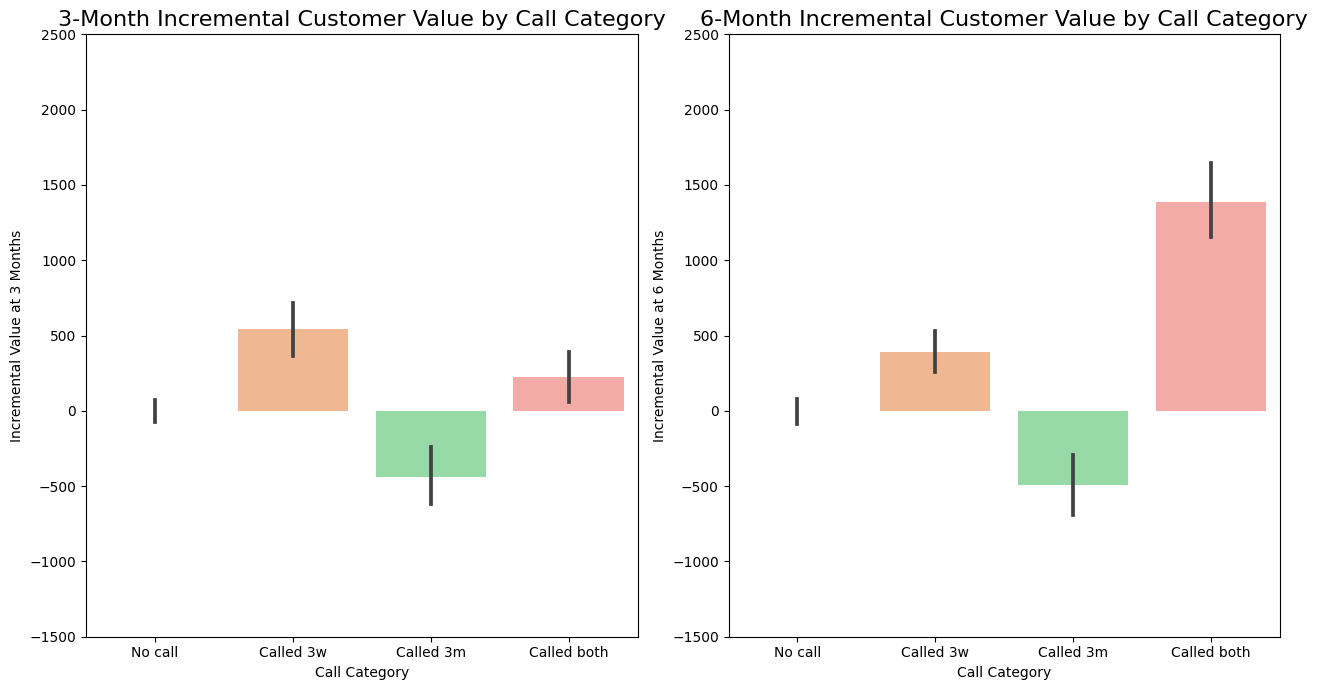

In [184]:
call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']

fig, axes = plt.subplots(1, 2,figsize=(13, 7))

# Plotting the Incremental Value for 3-month data
sns.barplot(data=df_3_V1, ax=axes[0],
            x='Call_Category', y='Incremental_Value_3m',
            palette="pastel", ci=95, order=call_order)
axes[0].set_title('3-Month Incremental Customer Value by Call Category', fontsize=16)
axes[0].set_xlabel('Call Category')
axes[0].set_ylabel('Incremental Value at 3 Months')
axes[0].set_ylim(-1500, 2500)  # Set y-axis limits for better comparison

# Plotting the Incremental Value for 6-month data
sns.barplot(data=df_6_V1, ax=axes[1],
            x='Call_Category', y='Incremental_Value_6m',
            palette="pastel", ci=95, order=call_order)
axes[1].set_title('6-Month Incremental Customer Value by Call Category', fontsize=16)
axes[1].set_xlabel('Call Category')
axes[1].set_ylabel('Incremental Value at 6 Months')
axes[1].set_ylim(-1500, 2500)  # Set y-axis limits for better comparison

plt.tight_layout()
plt.show()

Short Term Impact: Calling 3W seem to have the highest incremental value, while Calling 3M has negative incremental value compared to no call.

Long Term Impact: Calling Both has the highest incremental value, calling 3w is the second, while Calling 3M still has negative incremental value compared to no call.

Therefore, calling 3m is not a good strategy. We can further examine with more customer's demographic information to see if there is any pattern. 

## 3.2 Aggregate based on Call Category plus Payroll

In [185]:
df_3_V2 = df_3.copy()
df_6_V2 = df_6.copy()

In [186]:
# Calculate the average Customer Value Score for the 'No call' category considering 'Has_Payroll' and 'No_Payroll'

no_call_avg_values_3m = df_3_V2[df_3_V2['Call_Category'] == 'No call'].groupby('Has_Payroll')['Customer_Value'].mean()
no_call_avg_values_6m = df_6_V2[df_6_V2['Call_Category'] == 'No call'].groupby('Has_Payroll')['Customer_Value'].mean()

no_call_avg_values_3m, no_call_avg_values_6m

(Has_Payroll
 0    1695.316310
 1    1961.259893
 Name: Customer_Value, dtype: float64,
 Has_Payroll
 0    2494.062503
 1    2347.831558
 Name: Customer_Value, dtype: float64)

In [187]:
# Compute the Incremental_Value for each row based on its "Has_Payroll" condition 

df_3_V2['Incremental_Value_3m'] = df_3_V2.apply(lambda row: row['Customer_Value'] - no_call_avg_values_3m[row['Has_Payroll']], axis=1)
df_6_V2['Incremental_Value_6m'] = df_6_V2.apply(lambda row: row['Customer_Value'] - no_call_avg_values_6m[row['Has_Payroll']], axis=1)

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/85403493.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_3_V2, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

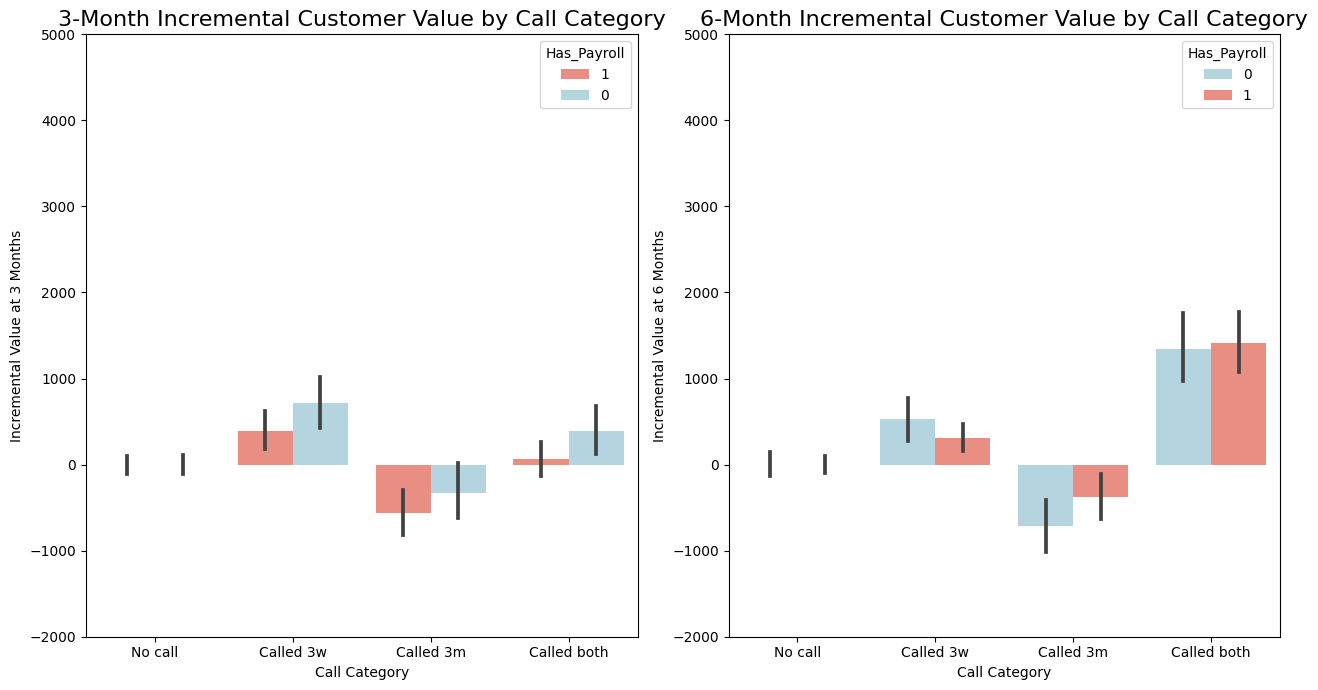

In [188]:
# Define a color palette dictionary for 'Has_Payroll'
palette_dict = {'0': 'lightblue', '1': 'salmon'}

# Plotting
call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']
fig, axes = plt.subplots(1, 2,figsize=(13, 7))

# Plotting the Incremental Value for 3-month data
sns.barplot(data=df_3_V2, ax=axes[0],
            x='Call_Category', y='Incremental_Value_3m', hue='Has_Payroll',
            palette=palette_dict, ci=95, order=call_order)
axes[0].set_title('3-Month Incremental Customer Value by Call Category', fontsize=16)
axes[0].set_xlabel('Call Category')
axes[0].set_ylabel('Incremental Value at 3 Months')
axes[0].set_ylim(-2000, 5000)  # Set y-axis limits for better comparison

# Plotting the Incremental Value for 6-month data
sns.barplot(data=df_6_V2, ax=axes[1],
            x='Call_Category', y='Incremental_Value_6m', hue='Has_Payroll',
            palette=palette_dict, ci=95, order=call_order)
axes[1].set_title('6-Month Incremental Customer Value by Call Category', fontsize=16)
axes[1].set_xlabel('Call Category')
axes[1].set_ylabel('Incremental Value at 6 Months')
axes[1].set_ylim(-2000, 5000)  # Set y-axis limits for better comparison

plt.tight_layout()
plt.show()



Taking Payroll into consideration, the pattern is similar to the one without payroll.

Calling 3m still has the most negative impact on incremental value. 

## 3.0 Aggregate based on Call Category plus Age

In [189]:
df_3_V3 = df_3.copy()
df_6_V3 = df_6.copy()

In [190]:
# Calculate the average Customer Value Score for the 'No call' category considering Age Bin

no_call_avg_values_3m = df_3_V3[df_3_V3['Call_Category'] == 'No call'].groupby(['Age_Bin'])['Customer_Value'].mean()
no_call_avg_values_6m = df_6_V3[df_6_V3['Call_Category'] == 'No call'].groupby(['Age_Bin'])['Customer_Value'].mean()


no_call_avg_values_3m, no_call_avg_values_6m

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/1981722185.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_3m = df_3_V3[df_3_V3['Call_Category'] == 'No call'].groupby(['Age_Bin'])['Customer_Value'].mean()
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/1981722185.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_6m = df_6_V3[df_6_V3['Call_Category'] == 'No call'].groupby(['Age_Bin'])['Customer_Value'].mean()


(Age_Bin
 Young          1690.458368
 Middle-aged    1841.409446
 Senior         1804.502542
 Name: Customer_Value, dtype: float64,
 Age_Bin
 Young          2229.409058
 Middle-aged    2418.222423
 Senior         2366.969304
 Name: Customer_Value, dtype: float64)

In [191]:
# Compute the Incremental_Value for each row based on its Has_Payroll and Age_Bin values

df_3_V3['Incremental_Value_3m'] = df_3_V3.apply(lambda row: row['Customer_Value'] - no_call_avg_values_3m[(row['Age_Bin'])], axis=1)
df_6_V3['Incremental_Value_6m'] = df_6_V3.apply(lambda row: row['Customer_Value'] - no_call_avg_values_6m[(row['Age_Bin'])], axis=1)

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/1710124313.py:1: FutureWarning: 

The `ci` parameter is deprecated.

(-2000.0, 2000.0)

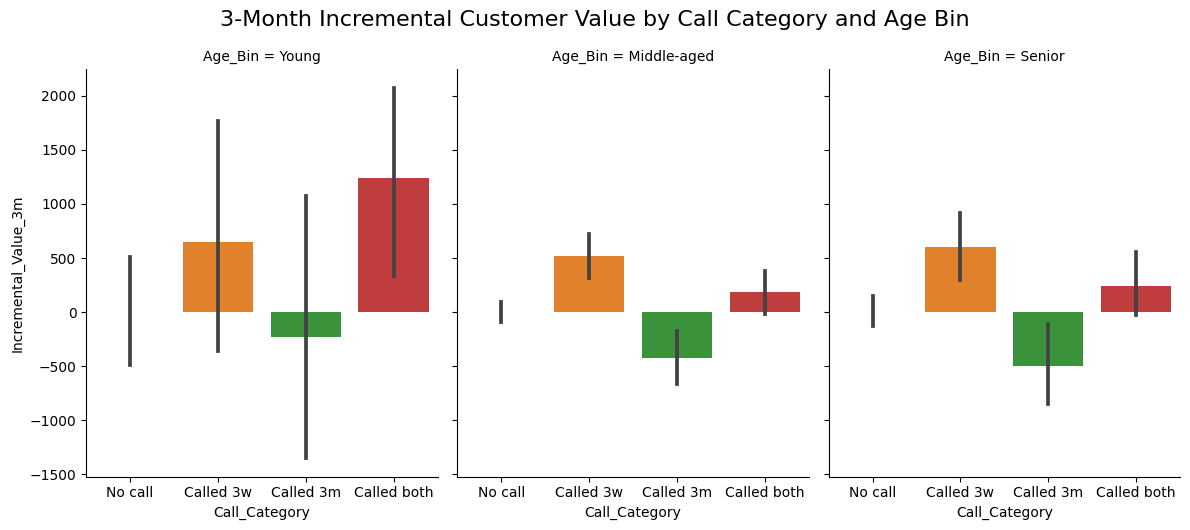

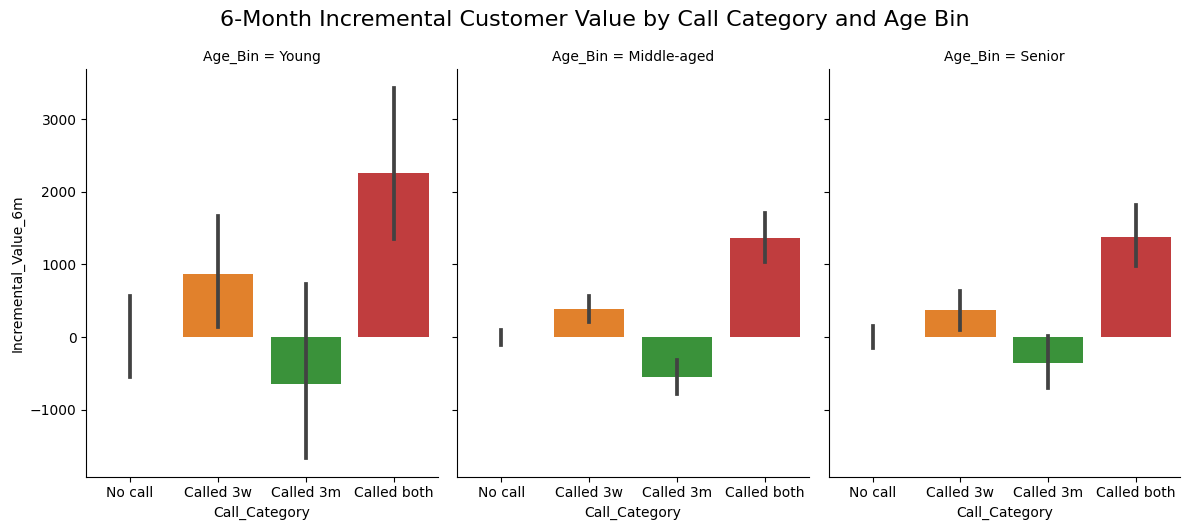

In [192]:
g_3m = sns.catplot(data=df_3_V3, ax=axes[0],
                   x='Call_Category', y='Incremental_Value_3m', col='Age_Bin',
                   ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category and Age Bin', fontsize=16, y=1.05)
axes[0].set_ylim(-2000, 2000)  # Set y-axis limits for better comparison

g_6m = sns.catplot(data=df_6_V3, ax=axes[1],
                   x='Call_Category', y='Incremental_Value_6m', col='Age_Bin',
                   ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category and Age Bin', fontsize=16, y=1.05)
axes[1].set_ylim(-2000, 2000)  # Set y-axis limits for better comparison

For short term, variability in young people is high, cannot conclude which is obviously better. Calling 3w seem to be better for middle age and senior

Calling both yields the best results in long term, regardless of age

The key question is who should we call? 

## 4.0 Aggregate based on Call Category plus Payroll, Age

4.1 Aggregate based on Payroll and Age

In [193]:
df_3_V4 = df_3.copy()
df_6_V4 = df_6.copy()

In [194]:
# Calculate the average Customer Value Score for the 'No call' category considering 'Has_Payroll' and 'No_Payroll'

no_call_avg_values_3m = df_3_V4[df_3_V4['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value'].mean()
no_call_avg_values_6m = df_6_V4[df_6_V4['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value'].mean()


no_call_avg_values_3m, no_call_avg_values_6m

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/741754302.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_3m = df_3_V4[df_3_V4['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value'].mean()
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/741754302.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_6m = df_6_V4[df_6_V4['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value'].mean()


(Has_Payroll  Age_Bin    
 0            Young          1825.798096
              Middle-aged    1715.237967
              Senior         1630.986587
 1            Young          1539.651243
              Middle-aged    1987.012778
              Senior         1933.911862
 Name: Customer_Value, dtype: float64,
 Has_Payroll  Age_Bin    
 0            Young          2270.614935
              Middle-aged    2459.274553
              Senior         2623.243392
 1            Young          2201.938473
              Middle-aged    2392.183643
              Senior         2272.520873
 Name: Customer_Value, dtype: float64)

In [195]:
# Compute the Incremental_Value for each row based on its Has_Payroll and Age_Bin values

df_3_V4['Incremental_Value_3m'] = df_3_V4.apply(lambda row: row['Customer_Value'] - no_call_avg_values_3m[(row['Has_Payroll'], row['Age_Bin'])], axis=1)
df_6_V4['Incremental_Value_6m'] = df_6_V4.apply(lambda row: row['Customer_Value'] - no_call_avg_values_6m[(row['Has_Payroll'], row['Age_Bin'])], axis=1)


/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/1574966508.py:3: FutureWar

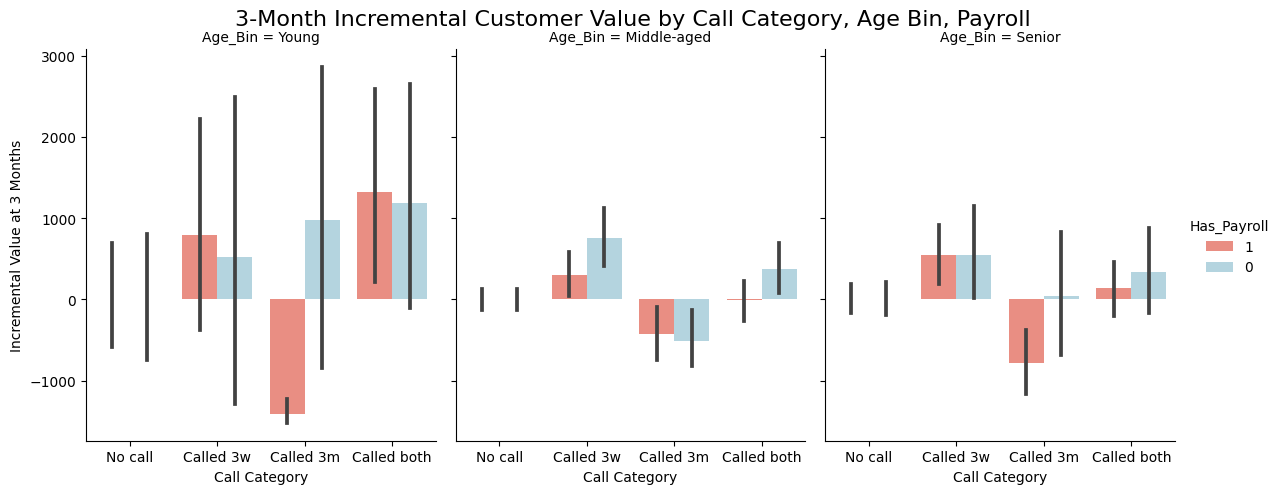

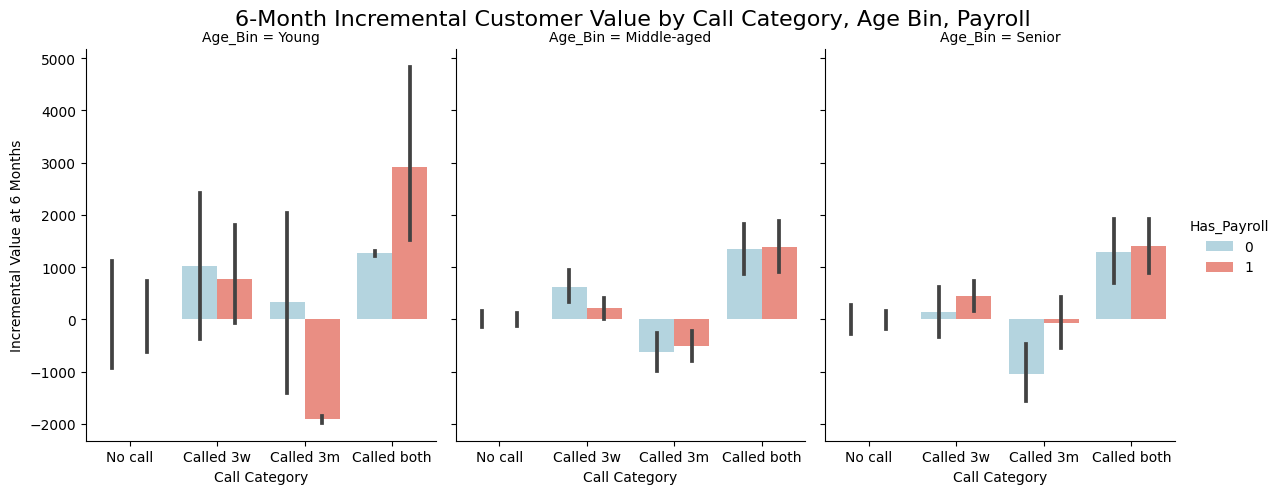

In [196]:
palette_dict = {'0': 'lightblue', '1': 'salmon'}

g_3m = sns.catplot(data=df_3_V4, 
                   x='Call_Category', y='Incremental_Value_3m', hue='Has_Payroll', col='Age_Bin',
                   palette=palette_dict, ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)

g_3m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category, Age Bin, Payroll', fontsize=16)
g_3m.set_axis_labels('Call Category', 'Incremental Value at 3 Months')


palette_dict = {'0': 'lightblue', '1': 'salmon'}

g_6m = sns.catplot(data=df_6_V4, 
                   x='Call_Category', y='Incremental_Value_6m', hue='Has_Payroll', col='Age_Bin',
                   palette=palette_dict, ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)

g_6m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category, Age Bin, Payroll', fontsize=16)
g_6m.set_axis_labels('Call Category', 'Incremental Value at 6 Months')


Calling seem to have more short term impact to those without payroll, also if you call client only once, people without payroll tend to react more than those with payroll

But in long term, calling both yields the best results in long term, people with payroll regardless of age brings in more value. To extract value from them, calling people with payroll twice is a better strategy. 

The order is young people with payroll, middle age with or without payroll, senior with or without payroll.  

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/515175840.py:8: FutureWarn

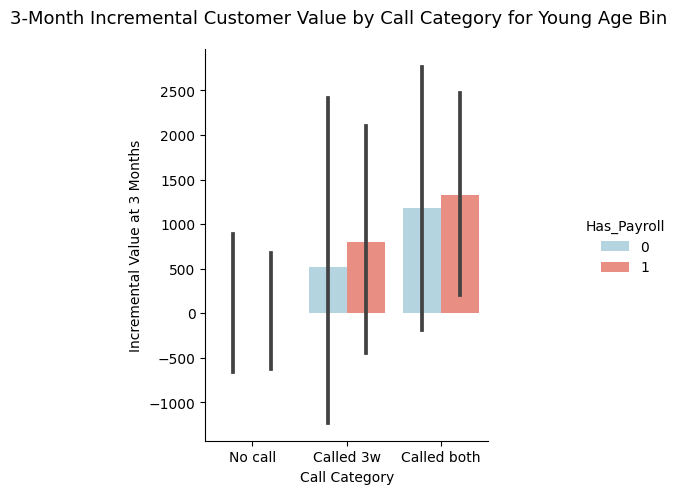

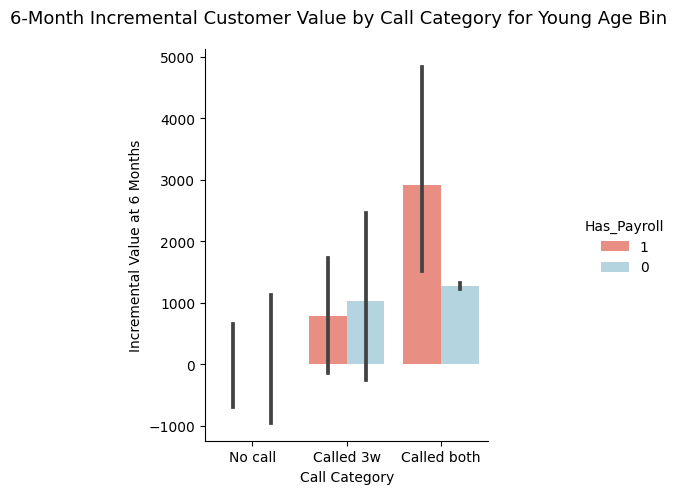

In [197]:
# Filter and subset data
filtered_call_categories = ["No call", "Called 3w", "Called both"]
df_3_young_filtered = df_3_V4[(df_3_V4['Age_Bin'] == 'Young') & (df_3_V4['Call_Category'].isin(filtered_call_categories))]
df_6_young_filtered = df_6_V4[(df_6_V4['Age_Bin'] == 'Young') & (df_6_V4['Call_Category'].isin(filtered_call_categories))]

palette_dict = {'0': 'lightblue', '1': 'salmon'}

g_3m = sns.catplot(data=df_3_young_filtered, 
                   x='Call_Category', y='Incremental_Value_3m', hue='Has_Payroll',
                   palette=palette_dict, ci=95, order=filtered_call_categories, kind='bar',
                   height=5, aspect=0.8)

g_3m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category for Young Age Bin', fontsize=13)
g_3m.set_axis_labels('Call Category', 'Incremental Value at 3 Months')

g_6m = sns.catplot(data=df_6_young_filtered, 
                   x='Call_Category', y='Incremental_Value_6m', hue='Has_Payroll',
                   palette=palette_dict, ci=95, order=filtered_call_categories, kind='bar',
                   height=5, aspect=0.8)

g_6m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category for Young Age Bin', fontsize=13)
g_6m.set_axis_labels('Call Category', 'Incremental Value at 6 Months')


## 5.0 Aggregate based on Call Category plus Payroll, Has_Mortgage

In [198]:
df_3_V5 = df_3.copy()
df_6_V5 = df_6.copy()

In [199]:
# Calculate the average Customer Value Score for the 'No call' category considering 'Has_Payroll' and 'Has_Investment'

no_call_avg_values_3m = df_3_V5[df_3_V5['Call_Category'] == 'No call'].groupby(['Has_mortgage'])['Customer_Value'].mean()
no_call_avg_values_6m = df_6_V5[df_6_V5['Call_Category'] == 'No call'].groupby(['Has_mortgage'])['Customer_Value'].mean()


no_call_avg_values_3m, no_call_avg_values_6m

(Has_mortgage
 0    1253.349537
 1    4281.116739
 Name: Customer_Value, dtype: float64,
 Has_mortgage
 0    1992.204143
 1    4119.904072
 Name: Customer_Value, dtype: float64)

In [200]:
# Compute the Incremental_Value for each row based on its Has_Payroll and Age_Bin values

df_3_V5['Incremental_Value_3m'] = df_3_V5.apply(lambda row: row['Customer_Value'] - no_call_avg_values_3m[(row['Has_mortgage'])], axis=1)
df_6_V5['Incremental_Value_6m'] = df_6_V5.apply(lambda row: row['Customer_Value'] - no_call_avg_values_6m[(row['Has_mortgage'])], axis=1)

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/1635181840.py:3: FutureWar

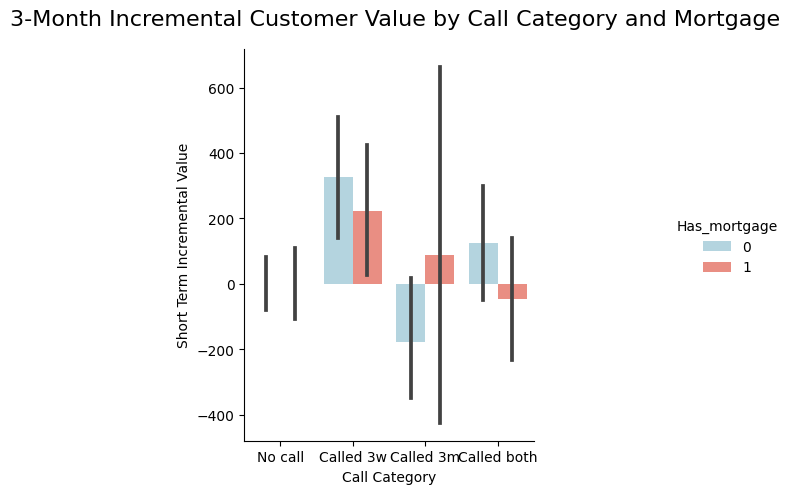

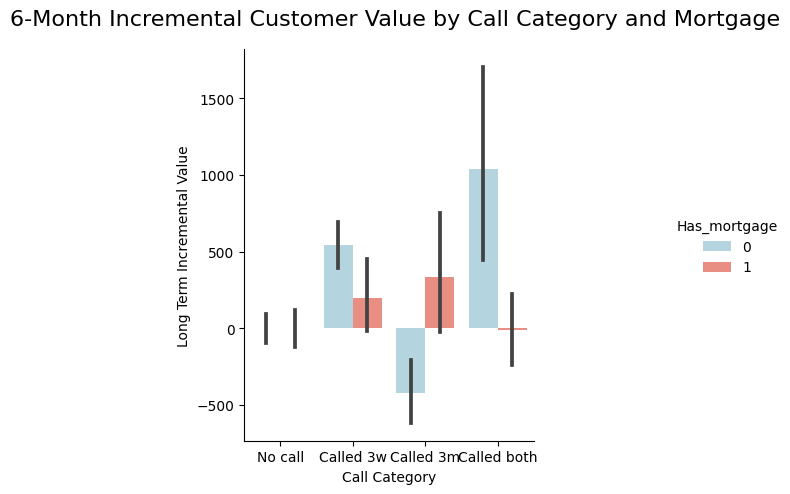

In [201]:
palette_dict = {'0': 'lightblue', '1': 'salmon'}

g_3m = sns.catplot(data=df_3_V5, 
                   x='Call_Category', y='Incremental_Value_3m', hue='Has_mortgage',
                   palette=palette_dict, ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)

g_3m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category and Mortgage', fontsize=16)
g_3m.set_axis_labels('Call Category', 'Short Term Incremental Value')


palette_dict = {'0': 'lightblue', '1': 'salmon'}

g_6m = sns.catplot(data=df_6_V5, 
                   x='Call_Category', y='Incremental_Value_6m', hue='Has_mortgage',
                   palette=palette_dict, ci=95, order=call_order, kind='bar',
                   height=5, aspect=0.8)

g_6m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category and Mortgage', fontsize=16)
g_6m.set_axis_labels('Call Category', 'Long Term Incremental Value')

## 6.0 Aggregate based on Call Category plus Payroll, VANCOUVER, SURREY

In [246]:
df_3["City"] = df_3["City"].str.strip()
df_6["City"] = df_6["City"].str.strip()

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/3479755022.py:22: FutureWa

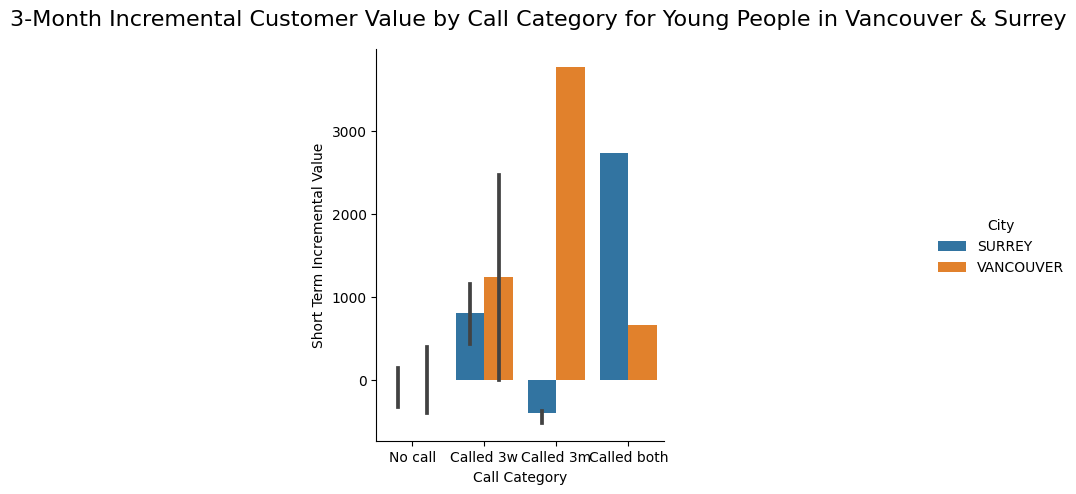

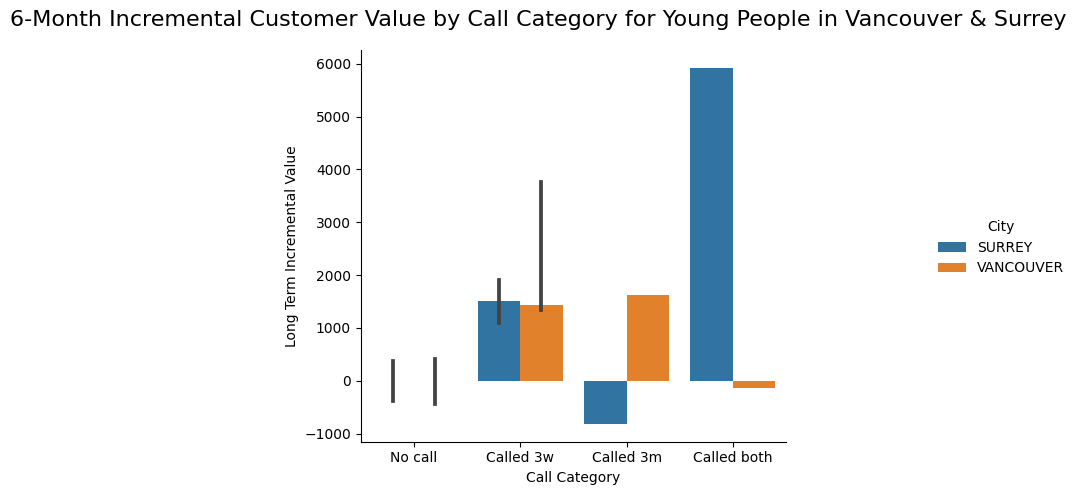

In [275]:
# Copy original dataframes
df_3_VS = df_3.copy()
df_6_VS = df_6.copy()

# Filter the data to only include Vancouver and Surrey, and Age_Bin = Young
cities = ['VANCOUVER', 'SURREY']
df_3_VS = df_3_VS[(df_3_VS['City'].isin(cities)) & (df_3_VS['Age_Bin'] == 'Young')]
df_6_VS = df_6_VS[(df_6_VS['City'].isin(cities)) & (df_6_VS['Age_Bin'] == 'Young')]

# Compute the Incremental_Value for each city
def compute_incremental_values(df, time_period):
    no_call_avg = df[df['Call_Category'] == 'No call']['Customer_Value'].mean()
    df[f'Incremental_Value_{time_period}'] = df['Customer_Value'] - no_call_avg
    return df

df_3_VS = df_3_VS.groupby('City').apply(lambda x: compute_incremental_values(x, '3m'))
df_6_VS = df_6_VS.groupby('City').apply(lambda x: compute_incremental_values(x, '6m'))

call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']

# Visualize 3-month data for both cities
g_3m = sns.catplot(data=df_3_VS, 
                   x='Call_Category', y='Incremental_Value_3m',
                   hue='City', kind='bar', ci=40,
                   height=5, aspect=0.8, order=call_order)

g_3m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category for Young People in Vancouver & Surrey', fontsize=16)
g_3m.set_axis_labels('Call Category', 'Short Term Incremental Value')

# Visualize 6-month data for both cities
g_6m = sns.catplot(data=df_6_VS, 
                   x='Call_Category', y='Incremental_Value_6m',
                   hue='City', kind='bar', ci=40,
                   height=5, aspect=0.8, order=call_order)

g_6m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category for Young People in Vancouver & Surrey', fontsize=16)
g_6m.set_axis_labels('Call Category', 'Long Term Incremental Value')
plt.tight_layout()

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_48946/2435810015.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 40)` for the same effect.

  g_3m = sns.catplot(data=df_3_VS,
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be

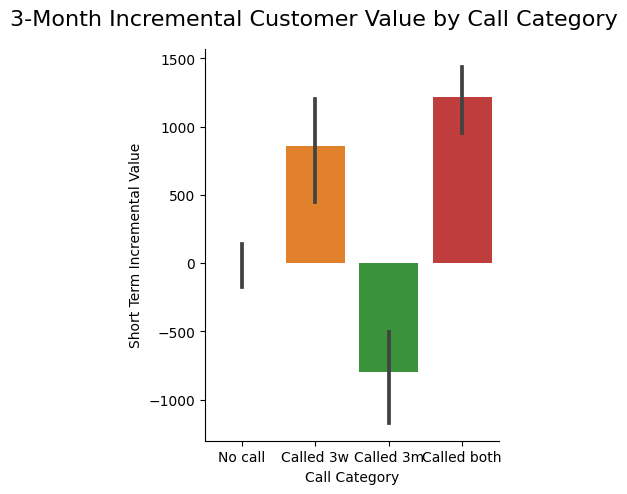

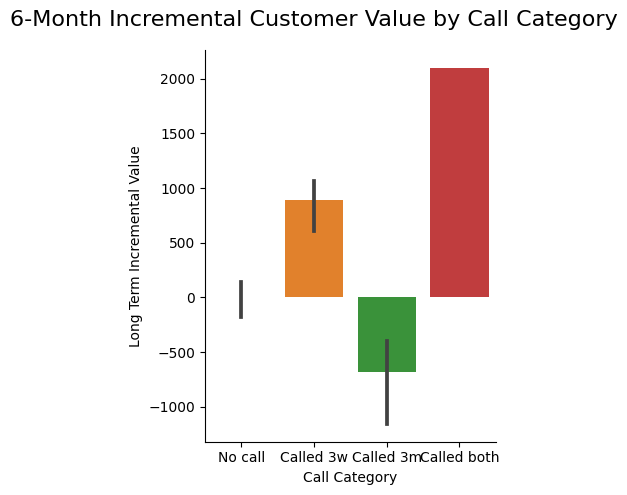

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original dataframes
df_3_VS = df_3.copy()
df_6_VS = df_6.copy()

# Filter the data to exclude Vancouver and Surrey, and only include Age_Bin = Young
cities = ['VANCOUVER', 'SURREY']
df_3_VS = df_3_VS[~(df_3_VS['City'].isin(cities)) & (df_3_VS['Age_Bin'] == 'Young')]
df_6_VS = df_6_VS[~(df_6_VS['City'].isin(cities)) & (df_6_VS['Age_Bin'] == 'Young')]

# Compute the Incremental_Value
def compute_incremental_values(df, time_period):
    no_call_avg = df[df['Call_Category'] == 'No call']['Customer_Value'].mean()
    df[f'Incremental_Value_{time_period}'] = df['Customer_Value'] - no_call_avg
    return df

df_3_VS = compute_incremental_values(df_3_VS, '3m')
df_6_VS = compute_incremental_values(df_6_VS, '6m')

call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']

# Visualize 3-month data
g_3m = sns.catplot(data=df_3_VS, 
                   x='Call_Category', y='Incremental_Value_3m',
                   kind='bar', ci=40,
                   height=5, aspect=0.8, order=call_order)

g_3m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_3m.fig.suptitle('3-Month Incremental Customer Value by Call Category', fontsize=16)
g_3m.set_axis_labels('Call Category', 'Short Term Incremental Value')

# Visualize 6-month data
g_6m = sns.catplot(data=df_6_VS, 
                   x='Call_Category', y='Incremental_Value_6m',
                   kind='bar', ci=40,
                   height=5, aspect=0.8, order=call_order)

g_6m.fig.subplots_adjust(top=0.9) # Adjusting for title space
g_6m.fig.suptitle('6-Month Incremental Customer Value by Call Category', fontsize=16)
g_6m.set_axis_labels('Call Category', 'Long Term Incremental Value')
plt.tight_layout()
